In [1]:
import numpy as np
import qutip as qt
import QuantumStuff as qs
import scipy.sparse as sp
from scipy.sparse.linalg import expm_multiply
from scipy.sparse import csc_matrix, csc_array

In [2]:
from scipy.special import comb
import sklearn.linear_model as LM

In [ ]:
def CD_training(sk: np.ndarray, y_target: np.ndarray, H1: np.ndarray | sp.csc_matrix | sp.csc_array, H0: np.ndarray | sp.csc_matrix | sp.csc_array, c_ops: list, δt: float, qq_op: list | None,  wo: int = 1000, train_size: int = 1000, state = None):
    
    Nq = int(np.log2(H0.shape[0]))
    if 
    if state is None:
        state = qs.zero(dm = True, N = Nq)
    statet = qs.QRC.CD_evolution(sk, H1, H0, c_ops, δt, wo + train_size, state)
    if qq_ops is None:
        qq_ops = [np.kron(qs.sigmax(),qs.sigmax()), np.kron(qs.sigmay(),qs.sigmay()), np.kron(qs.sigmaz(),qs.sigmaz())]
    #Measurements
    if Nq != 1:
        x_train = np.real(np.hstack((qs.measure(statet, [qs.sigmax(), qs.sigmay(), qs.sigmaz()]).reshape(wo+train_size, 3*Nq), qs.measure(statet, qq_op).reshape(wo + train_size, int(len(tqo)*comb(Nq, 2))), np.ones((wo+train_size, 1)))))
    else:
        x_train = np.real(np.hstack(((qs.measure(statet).reshape(wo+train_size, 3*Nq), np.ones((wo+train_size, 1))))))

    #Training
    alpha = np.logspace(-9,3,1000)
    ridge = LM.RidgeCV(alphas = alpha)
    ## For forecasting problems y_target = sk[wo+1:wo+train_size+1]
    ridge.fit((x_train[wo:]), y_target)

    return ridge, x_train, statet[-1]

In [2]:
from scipy.sparse import csc_array
Nq = 5
J = qs.random_coupling(1, Nq)
X = qs.local_operators(qs.sigmax(), Nq)
Z = qs.local_operators(qs.sigmaz(), Nq)
H0 = csc_matrix(qs.interaction(X, J))
h = 0.1
g = 0.1
H1 = csc_matrix(np.sum(h * Z, 0))
H = H0 + H1
H2 = csc_matrix(np.sum(h * X, 0))
state = qs.zero(dm = True, N = Nq)
sk = np.load("../Input_MG.npy")
cops = qs.local_operators(csc_array(np.sqrt(g)*qs.sigmam()), Nq)

In [3]:
ridge, x_train, state_out = CD_training(sk, sk[1000:2000], H2, H, cops, 0.01)

NameError: name 'CD_training' is not defined

In [7]:
H0 = qt.Qobj(H0.toarray(), dims=[[2]*Nq, [2]*Nq])
H1 = qt.Qobj(H1.toarray(), dims=[[2]*Nq, [2]*Nq])
H = H0 + H1
H2 = qt.Qobj(H2.toarray(), dims=[[2]*Nq, [2]*Nq])
cops = [qt.Qobj(cop.toarray(), dims=[[2]*Nq, [2]*Nq]) for cop in cops]

AttributeError: 'Qobj' object has no attribute 'toarray'

In [8]:
from qutip import tensor, qeye, sigmax, sigmay, sigmaz

# Number of qubits
n_qubits = 5

# Define Pauli matrices
paulis = {'x': sigmax(), 'y': sigmay(), 'z': sigmaz()}

# Identity operator for single qubit
id_op = qeye(2)

# List to hold local and two-qubit operators
local_ops = []
two_qubit_ops = []

# Create local single-qubit operators
for i in range(n_qubits):
    for label, op in paulis.items():
        op_list = [id_op] * n_qubits
        op_list[i] = op
        local_ops.append(tensor(op_list))

# Create two-qubit operators of the type xx, yy, zz
for i in range(n_qubits):
    for j in range(i+1, n_qubits):
        for label, op in paulis.items():
            op_list = [id_op] * n_qubits
            op_list[i] = op
            op_list[j] = op
            two_qubit_ops.append(tensor(op_list))

# Optional: combine all operators in a single list if needed
all_ops = local_ops + two_qubit_ops

# Example: print number of operators
print(f"Number of local operators: {len(local_ops)}")
print(f"Number of two-qubit operators: {len(two_qubit_ops)}")
print(f"Total number of operators: {len(all_ops)}")

Number of local operators: 15
Number of two-qubit operators: 30
Total number of operators: 45


In [9]:
from qutip import tensor, qeye, sigmax, sigmay, sigmaz, basis, expect, mesolve, sigmam
import numpy as np
from tqdm import tqdm

# Number of qubits
n_qubits = 5

# Define Pauli matrices
paulis = {'x': sigmax(), 'y': sigmay(), 'z': sigmaz()}

# Identity operator for single qubit
id_op = qeye(2)

# List to hold local and two-qubit operators
local_ops = []
two_qubit_ops = []

# Create local single-qubit operators
for i in range(n_qubits):
    for label, op in paulis.items():
        op_list = [id_op] * n_qubits
        op_list[i] = op
        local_ops.append(tensor(op_list))

# Create two-qubit operators of the type xx, yy, zz
for i in range(n_qubits):
    for j in range(i+1, n_qubits):
        for label, op in paulis.items():
            op_list = [id_op] * n_qubits
            op_list[i] = op
            op_list[j] = op
            two_qubit_ops.append(tensor(op_list))

# Combine all operators
all_ops = local_ops + two_qubit_ops

# Initial state (e.g., all qubits in ground state |0>)

# Time steps and duration
timesteps = 31
dt = 0.01
times = np.linspace(0, dt, 2)  # short evolution interval

# Function to generate a time-dependent Hamiltonian (e.g., random local field

# Collapse operators for decoherence (e.g., amplitude damping on each qubit)
gamma = 0.1  # decoherence rate
c_ops = []
for i in range(n_qubits):
    lowering_op = tensor([sigmam() if j == i else id_op for j in range(n_qubits)])  # Replace with lowering if needed
    c_ops.append(np.sqrt(gamma) * lowering_op)

# List to store expectation values
expectation_values = []

# Current state
state = qt.Qobj(state, dims = [[2]*n_qubits, [2]*n_qubits])  # Convert to Qobj if needed

# Time evolution using the master equation with changing Hamiltonian
for step in tqdm(range(timesteps)):
    Htot = H + (1+sk[step])*H2
    result = mesolve(Htot, state, times, c_ops)
    state = result.states[-1]  # Update state
    exp_vals = [expect(op, state) for op in all_ops]
    expectation_values.append(exp_vals)

# Example: print expectation values at the last step
print("Expectation values at final timestep:")
print(expectation_values[-1])


100%|██████████| 31/31 [00:13<00:00,  2.32it/s]

Expectation values at final timestep:
[0.001399848137449255, -0.01696417411366186, 0.16255667380303343, 0.0018083383156385297, -0.03355872873026485, 0.3251477450844211, 0.0015272784583751514, -0.021165442835744678, 0.20913652035496313, 0.0020261861620456947, -0.04505973319520247, 0.45398120348821663, 0.0015679281057488792, -0.0230172723988779, 0.22593298681105897, 0.03602280362157642, -0.01842561375239545, 0.05846282206953801, -0.029503690016496942, 0.032871657684748506, -0.0031841986809770066, -0.0373682790401767, 0.26990793968630666, 0.2893420549069778, -0.022823500315972283, 0.41070471530600144, 0.3999473130573074, -0.023811313561021605, -0.35423843901746105, 0.3975767098333322, 0.002324490905639964, -0.2389344184326201, 0.15145523270341818, 0.028525716008088536, 0.006168179075500912, -0.06454231120542012, -0.017699701069290547, 0.30078258429911287, 0.2897792479515612, -0.04142634963971993, 0.11650940830087242, 0.10105182873128755, -0.017640123898573563, 0.29660859426046743, 0.29065

In [100]:
import quantum_stuff as qso
import numpy as np
from scipy.sparse import csc_array
import sklearn.linear_model as LM
import QuantumStuff as qs
sk = np.load("../Input_MG.npy")
dt = 0.02
h = 6
gamma = [0.01, 0.02,0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,20]
Nq = 5
wo = 1000
train_size = 1000
test_size = 1500
Js = 1
sx = qs.sigmax()
sz = qs.sigmaz()
sm = qs.sigmam()
X = qs.local_operators(sx, Nq)
Z = qs.local_operators(sz, Nq)
np.random.seed()
J = qs.random_coupling(Js, Nq)
# np.save(fname+"_coupling.npy", J)
H1 = csc_array(h*np.sum(X,0))
H0 = csc_array(np.sum(qs.interaction(X, J) + h*Z,0))
cops = qs.local_operators(np.sqrt(10)*sm, Nq)
cops = [csc_array(c, dtype = complex) for c in cops]
state = qs.QRC.CD_evolution(sk, H1, H0, cops, dt, wo + train_size+test_size)

  0%|          | 0/3500 [00:00<?, ?it/s]

100%|██████████| 3500/3500 [02:29<00:00, 23.39it/s]


In [91]:
qs.measure(state, [qs.sigmax(), qs.sigmay(), qs.sigmaz()]).shape

(3500, 3, 5)

In [101]:
from scipy.special import comb
sy = qs.sigmay()
sx = qs.sigmax()
sz = qs.sigmaz()
tqo = [np.kron(sx, sx), np.kron(sy, sy), np.kron(sz, sz)]    
x_train = np.hstack((qs.measure(state, [sx,sy,sz]).reshape(wo + train_size+ test_size, 3*Nq), qs.measure(state, tqo).reshape(wo + train_size+ test_size,int(len(tqo)*comb(Nq, 2))), np.ones((wo+train_size+test_size, 1))))
x_train = np.real(x_train)
alpha = np.logspace(-9,3,1000)
ridge = LM.RidgeCV(alphas = alpha)
tau = 1
y_target = sk[wo+tau:wo+train_size+tau]
y_target = np.asarray(y_target)

ridge.fit((x_train[wo:wo + train_size]), y_target)
print(ridge)

RidgeCV(alphas=array([1.00000000e-09, 1.02804473e-09, 1.05687597e-09, 1.08651577e-09,
       1.11698682e-09, 1.14831241e-09, 1.18051653e-09, 1.21362380e-09,
       1.24765955e-09, 1.28264983e-09, 1.31862140e-09, 1.35560179e-09,
       1.39361927e-09, 1.43270295e-09, 1.47288272e-09, 1.51418933e-09,
       1.55665436e-09, 1.60031031e-09, 1.64519059e-09, 1.69132952e-09,
       1.73876240e-09, 1.78752553e-0...
       5.29326606e+02, 5.44171429e+02, 5.59432571e+02, 5.75121707e+02,
       5.91250841e+02, 6.07832313e+02, 6.24878807e+02, 6.42403366e+02,
       6.60419396e+02, 6.78940681e+02, 6.97981391e+02, 7.17556092e+02,
       7.37679760e+02, 7.58367791e+02, 7.79636013e+02, 8.01500696e+02,
       8.23978568e+02, 8.47086827e+02, 8.70843150e+02, 8.95265713e+02,
       9.20373200e+02, 9.46184819e+02, 9.72720319e+02, 1.00000000e+03]))


In [102]:
state_target = state[wo + train_size:wo + test_size + train_size]

In [103]:
state_target = state_target.reshape(150,10,2**Nq,2**Nq)

In [104]:
preds = []
for j in range(10):
    state_test = state[wo + train_size +150*j - 1]
    ypred = [sk[wo + train_size +150*j+ i - 1] for i in range(1, tau+1)]
    test_size = 150
    superd = qs.Super_D(cops)
    for i in range(test_size):
        superh = qs.Super_H(H0 + (ypred[i] + 1)*H1)
        state_test = qs.Lindblad_Propagator(superh, superd, dt, state_test).reshape(2**Nq, 2**Nq)
        x_test = np.hstack((qs.measure(state_test, [sx,sy,sz]).reshape(1, 3*Nq), qs.measure(state_test, tqo).reshape(1,int(len(tqo)*comb(Nq, 2))), np.ones((1, 1))))

        x_test = np.real(x_test).reshape(1,-1)
        prd = ridge.predict(x_test)[0]
        if prd <0:
            prd = 0
        if prd > 1:
            prd = 1
        ypred.append(prd)
    preds.append(ypred)
        

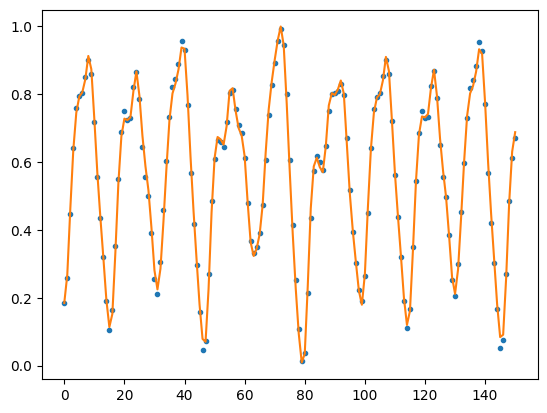

In [105]:
import matplotlib.pyplot as plt
plt.plot(preds[0], '.')
plt.plot(sk[wo + train_size+(150*0):wo + train_size + test_size + tau+(150*0)])

In [201]:
from tqdm import tqdm
import numpy as np
# gamma = [0.01, 0.02,0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1,2,3,4,5,6,7,8,9,10,20, 30,40,50,60,70,80,90,100]
ensemble = 96
# gamma = np.logspace(-2, 2, 50)
gamma = np.logspace(0, 3, 50)  # Logarithmic spacing for gamma values
gamma = np.delete(gamma, 9,axis = 0)
# gamma = np.linspace(1,15, 100)
# gamma = np.delete(gamma, 7,axis = 0)  # Remove the
# gamma = np.delete(gamma, 41,axis = 0)  # Remove the
xtest_real = np.zeros((len(gamma), 1, ensemble, 10,150,1, 46))
xtest = np.zeros((len(gamma), 1, ensemble, 10,150,1, 46))
# gamma = gamma[1::2]
# td = np.zeros((len(gamma), 1, ensemble, 1000))
for k in tqdm(range(len(gamma))):

    for t in range(1,2):
        for i in range(ensemble):
            directory = f'../Codici/Variation_coupling/Variation_coupling/{gamma[k]}/{t}/'
            xtest[k][t-1][i] = np.real(np.load(f'{directory}{i}_xtest.npz')['arr_0'])
            xtest_real[k][t-1][i] = np.real(np.load(f'{directory}{i}_xtest_real.npz')['arr_0'])
            


100%|██████████| 49/49 [03:36<00:00,  4.43s/it]


In [821]:
ensemble = 96
# gamma = np.logspace(-2, 2, 50)
# gamma = np.delete(gamma, 7,axis = 0)  # Remove the
# gamma = np.delete(gamma, 41,axis = 0)  # Remove the
td = np.zeros((len(gamma), ensemble, 1000))
for k in tqdm(range(len(gamma))):
    for i in range(ensemble):
        directory = f'../Codici/Variation_coupling/Variation_coupling/{gamma[k]}/{1}/'
        td[k][i] = np.real(np.load(f'{directory}{i}_td.npz')['arr_0'])

100%|██████████| 48/48 [01:04<00:00,  1.35s/it]


In [732]:
plt.loglog(gamma, np.median(np.mean(td,-1),-1))
plt.show()

In [822]:
x1 = np.zeros((len(gamma), ensemble, 1000,46))
x2 = np.zeros((len(gamma), ensemble, 1000, 46))
for k in tqdm(range(len(gamma))):
    for i in range(ensemble):
        directory = f'../Codici/Variation_coupling/Variation_coupling/{gamma[k]}/{t}/'
        x1[k,i] = np.load(f'{directory}{i}_x1.npz')['arr_0']
        x2[k,i] = np.load(f'{directory}{i}_x2.npz')['arr_0']

100%|██████████| 48/48 [04:37<00:00,  5.78s/it]


In [823]:
def standardize(arr):
    return (arr - np.mean(arr,1)[:,np.newaxis]) / np.std(arr,1)[:,np.newaxis]
standardized_x1 = np.zeros((len(gamma), ensemble, 1000, 46))
standardized_x2 = np.zeros((len(gamma), ensemble, 1000, 46))
for i in tqdm(range(48)):
    for j in range(96):
        standardized_x1[i,j] = standardize(x1[i,j])
        standardized_x2[i,j] = standardize(x2[i,j])

100%|██████████| 48/48 [00:04<00:00,  9.97it/s]


In [738]:
np.delete(x1, 45, axis=-1).shape

(48, 96, 1000, 45)

In [824]:
from scipy.stats import pearsonr
consistency = pearsonr(standardized_x1, standardized_x2, axis = 2)

In [825]:
consistency_m = np.median(np.mean(consistency.correlation, axis = 2), axis = 1)
consistencyq1 = np.quantile(np.mean(consistency.correlation, axis = 2), 0.25, axis = 1)
consistencyq3 = np.quantile(np.mean(consistency.correlation, axis = 2), 0.75, axis = 1)

(48, 96, 1000, 45)

In [754]:

plt.loglog(gamma, consistency_m, '.-')
plt.show()

In [14]:
import matplotlib
matplotlib.use('qtagg')

In [213]:

ytest = np.zeros((len(gamma), 1, ensemble, 10,150))
gamma = np.logspace(-2, 2, 50)
gamma = np.delete(gamma, 7,axis = 0)
gamma = np.delete(gamma, 41,axis = 0)

for k in tqdm(range(len(gamma))):

    for t in range(1,2):
        for i in range(ensemble):
            directory = f'../Codici/Variation_Gamma_renorm/Variation_Gamma/{gamma[k]}/{t}/'
            a = np.real(np.load(f'{directory}{i}_ypred.npz')['arr_0'])[:,t:]
            ytest[k][t-1][i] = a
            # ytest_real[k][t-1] = np.real(np.load(f'{directory}{i}_xtest_real.npz')['arr_0'])

sk = np.load("../Input_MG.npy")
ytarget = [[sk[2000 + i*150 + t:2000 + (i+1)*150 + t] for i in range(10)] for t in range(1,5)]

from sklearn.metrics import mean_squared_error as MSE
mse = np.zeros((len(gamma), 1, ensemble))
for i in range(len(gamma)):
    for j in range(1):
        for k in range(ensemble):
            mse[i][j][k] = MSE(ytest[i][j][k], ytarget[j])

100%|██████████| 48/48 [00:53<00:00,  1.11s/it]


In [869]:
xtest = xtest[:50]
xtest_real = xtest_real[:50]

In [203]:
dist = np.mean(np.median(np.linalg.norm((xtest[:,0,:]) - (xtest_real[:,0,:]), axis = -1, ord = 20), axis = 1), axis = 1)

In [96]:
plt.figure()
plt.plot(np.polyval(coeff[0], range(150)))
plt.plot(np.log(dist[0,:,0]))
plt.show()

C:\Users\marco\AppData\Local\Temp\ipykernel_13516\2669303296.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(dist[0,:,0]))


In [141]:
np.save('../dist_gamma.npy', dist)

In [832]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'no-latex'])

fig, ax = plt.subplots(figsize=(8, 6), nrows = 3)
ax[0].loglog(gamma, np.median(td, axis = 1)[:,-1], '.-', color ='orange')
ax[0].fill_between(gamma, np.percentile(td, 25, axis = 1)[:,-1], np.percentile(td, 75, axis = 1)[:,-1], alpha=0.2, color ='orange')
ax[1].loglog(gamma, np.median(mse, axis = -1)[:,0], '.-')
ax[1].fill_between(gamma, np.quantile(mse,q =0.25,axis = 2)[:,0], np.quantile(mse,q =0.75,axis = 2)[:,0], alpha=0.2, color = 'blue')
ax[2].loglog(gamma, 1-consistency_m, '.-',color = 'green')
ax[2].fill_between(gamma, 1-consistencyq1, 1-consistencyq3, alpha=0.2, color = 'green')
ax[2].set_xlabel(r'$\gamma$')
ax[2].set_ylabel(r'$\Gamma$')
ax[0].set_ylabel(r'$T(\rho, \sigma)$')
ax[1].set_ylabel(r'MSE($y_t$,$\bar{y}_t$)')
ax[0].text(0.05, 0.1, '(a)', transform=ax[0].transAxes,
         fontsize=10, fontweight='black', va='bottom', ha='left')
ax[1].text(0.05, 0.1, '(b)', transform=ax[1].transAxes,
         fontsize=10, fontweight='black', va='bottom', ha='left')
ax[2].text(0.05, 0.1, '(c)', transform=ax[2].transAxes,
         fontsize=10, fontweight='black', va='bottom', ha='left')
# plt.savefig('../Codici/Results/trace_distance_gamma.pdf', bbox_inches='tight', format = 'pdf')
plt.show()


In [836]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Load correct dataset
data = dist[:,:,0] # expected shape (6, N)
# data = distq1[:,:,0] # expected shape (6, N)
# data = distq2[:,:,0] # expected shape (6, N)

x = np.arange(data.shape[1])
# Define candidate fitting models
def linear(x, a, b):
    return a * x + b

def exponential(x, a, b, c):
    return a * np.exp(b * x) + c

def power_law(x, a, b, c):
    return a * np.power(x, b) + c

def logarithmic(x, a, b):
    return a * np.log(x + 1) + b  # shift to avoid log(0)

def power_law_plateau(x, a, alpha,b ):
    """
    A function that behaves like a power law at small x
    and goes to a plateau (a) at large x.

    Parameters:
    - x: input variable (numpy array or float)
    - a: plateau value as x -> infinity
    - b: scaling factor
    - alpha: power-law exponent

    Returns:
    - y: function value
    """
    return a * (x**alpha/ (1 + (x / b)**alpha))
def logistic(x,a,b,c,d,e):
    return a*(1+b*np.exp(-c*(x-d)))**(1/e)
# models = [power_law]
models = [power_law_plateau]

# model_names = ["Logistic"]
# model_names = ["Power-Law"]
model_names = ["Plateau"]

# Store best model info
best_models = {}

# Fitting loop
for i, y in enumerate(data):
    print(f"\nFitting dataset {i}:")
    best_mse = float('inf')
    best_model_name = None
    best_params = None

    for model, name in zip(models, model_names):
        popt, _ = curve_fit(model, x, y, maxfev=500000)
        print(popt)
        y_fit = model(x, *popt)
        mse2 = np.mean((y - y_fit) ** 2)
        print(f"  {name} fit error: {mse2:.6f}")
        if mse2 < best_mse:
            best_mse = mse2
            best_model_name = name
            best_params = popt


    best_models[f"Dataset_{i}"] = {
        "model": best_model_name,
        "mse": best_mse,
        "params": best_params.tolist() if best_params is not None else None
    }

# Save best fitting model info to a JSON file
import json
with open("best_fits.json", "w") as f:
    json.dump(best_models, f, indent=4)

print("\nBest fitting models saved to 'best_fits.json'")



Fitting dataset 0:


C:\Users\marco\AppData\Local\Temp\ipykernel_4532\2690760909.py:38: RuntimeWarning:

divide by zero encountered in power

C:\Users\marco\AppData\Local\Temp\ipykernel_4532\2690760909.py:38: RuntimeWarning:

invalid value encountered in divide



[6.21574286e-05 1.17186018e+00 6.13409702e+01]
  Plateau fit error: 0.000000

Fitting dataset 1:
[7.86110322e-05 1.05043578e+00 1.80891735e+02]
  Plateau fit error: 0.000000

Fitting dataset 2:
[8.89045294e-05 1.05089740e+00 2.14929815e+02]
  Plateau fit error: 0.000001

Fitting dataset 3:
[6.83879713e-05 1.13381848e+00 3.03460464e+02]
  Plateau fit error: 0.000001

Fitting dataset 4:
[5.88199128e-05 1.20566578e+00 2.11389538e+02]
  Plateau fit error: 0.000001

Fitting dataset 5:
[5.79561220e-05 1.18373734e+00 3.84031824e+02]
  Plateau fit error: 0.000002

Fitting dataset 6:
[5.10381794e-05 1.22916097e+00 3.85193452e+02]
  Plateau fit error: 0.000002

Fitting dataset 7:
[5.39601053e-05 1.18925939e+00 2.44698887e+03]
  Plateau fit error: 0.000003

Fitting dataset 8:
[4.37358495e-05 1.22640213e+00 2.11664511e+07]
  Plateau fit error: 0.000002

Fitting dataset 9:
[2.65803684e-05 1.35720696e+00 8.74381829e+06]
  Plateau fit error: 0.000003

Fitting dataset 10:
[1.29663733e-05 1.52168360e+0

C:\Users\marco\AppData\Local\Temp\ipykernel_4532\2690760909.py:38: RuntimeWarning:

invalid value encountered in power



[2.06892073e-02 2.75989627e-01 9.19207299e+18]
  Plateau fit error: 0.000099

Fitting dataset 38:
[0.01223836 1.12449295 5.09335717]
  Plateau fit error: 0.000155

Fitting dataset 39:
[3.62133780e-02 3.51328021e-01 5.66615418e+01]
  Plateau fit error: 0.000163

Fitting dataset 40:
[0.03408754 0.76308805 2.94367633]
  Plateau fit error: 0.000104

Fitting dataset 41:
[0.03648801 0.6142277  3.57196067]
  Plateau fit error: 0.000123

Fitting dataset 42:
[4.60246970e-02 8.74165184e-02 1.33879327e+30]
  Plateau fit error: 0.000150

Fitting dataset 43:
[0.04541666 0.87914729 1.6219534 ]
  Plateau fit error: 0.000130

Fitting dataset 44:
[0.04886893 1.01098147 1.31954406]
  Plateau fit error: 0.000122

Fitting dataset 45:
[0.0859823  0.44628879 0.67911748]
  Plateau fit error: 0.000125

Fitting dataset 46:
[4.59177935e-02 9.57283858e-02 6.30292626e+25]
  Plateau fit error: 0.000125

Fitting dataset 47:
[0.04277975 0.52439355 4.17986076]
  Plateau fit error: 0.000161

Best fitting models saved 

(150,)

In [837]:
with open("best_fits.json", "r") as f:
    best_models = json.load(f)
print(best_models)

{'Dataset_0': {'model': 'Plateau', 'mse': 3.4392252681853895e-07, 'params': [6.215742859452118e-05, 1.1718601813551517, 61.340970205954534]}, 'Dataset_1': {'model': 'Plateau', 'mse': 4.905007258889987e-07, 'params': [7.861103224043752e-05, 1.050435777958469, 180.8917353215186]}, 'Dataset_2': {'model': 'Plateau', 'mse': 8.201364854545487e-07, 'params': [8.890452941800873e-05, 1.05089740076209, 214.92981473816909]}, 'Dataset_3': {'model': 'Plateau', 'mse': 1.3750826919252513e-06, 'params': [6.838797132485556e-05, 1.133818480237548, 303.46046425602566]}, 'Dataset_4': {'model': 'Plateau', 'mse': 1.4913498297988595e-06, 'params': [5.88199127542201e-05, 1.20566578296608, 211.38953813513277]}, 'Dataset_5': {'model': 'Plateau', 'mse': 1.745304430282397e-06, 'params': [5.795612203164766e-05, 1.1837373409612806, 384.03182356982836]}, 'Dataset_6': {'model': 'Plateau', 'mse': 2.22844247710798e-06, 'params': [5.1038179382625285e-05, 1.22916097279994, 385.1934518599985]}, 'Dataset_7': {'model': 'Pla

In [839]:

import json

model_funcs = {
    # "Power-Law": power_law,
    "Plateau": power_law_plateau
    # "Logistic": logistic
}

def compare_fits(data_path, json_path, dataset_indices=None):
    # Load data and best model info
    data = data_path  # Assuming data is already loaded as a numpy array
    with open(json_path, "r") as f:
        best_models = json.load(f)

    x = np.arange(data.shape[1])
    indices = dataset_indices if dataset_indices is not None else range(data.shape[0])

    for i in indices:
        y = data[i]
        model_name = best_models[f"Dataset_{i}"]["model"]
        params = best_models[f"Dataset_{i}"]["params"]

        if model_name is None or params is None:
            print(f"Skipping Dataset {i} due to missing fit.")
            continue

        model_func = model_funcs[model_name]
        y_fit = model_func(x, *params)

        plt.figure(figsize=(8, 4))
        plt.plot(x, y, 'b.', label='Data')
        plt.plot(x, y_fit, 'r-', label=f'{model_name} fit')
        plt.title(f'Dataset {i} - Best Fit: {model_name}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Example usage:
# compare_fits(dist[:,:,0], "best_fits.json")
# compare_fits(distq1[:,:,0], "best_fitsq1.json")
compare_fits(dist[:,:,0], "best_fits.json")

In [840]:
with open("best_fits.json", "r") as f:
    best_models = json.load(f)
with open("best_fitsq1.json", "r") as f:
    best_modelsq1 = json.load(f)
with open("best_fitsq2.json", "r") as f:
    best_modelsq2 = json.load(f)
exponents = [best_models[f'Dataset_{i}']['params'][1] for i in range(len(gamma))]
# exponentsq1 = [best_modelsq1[f'Dataset_{i}']['params'][1] for i in range(len(gamma))]
# exponentsq2 = [best_modelsq2[f'Dataset_{i}']['params'][1] for i in range(len(gamma))]


In [794]:
data = dist[:,:,0]
x = np.arange(data.shape[1])

indices = range(data.shape[0])
plt.figure()
eps = np.zeros((len(gamma)))
for i in indices:
    y = data[i]
    model_name = best_models[f"Dataset_{i}"]["model"]
    params = best_models[f"Dataset_{i}"]["params"]

    if model_name is None or params is None:
        print(f"Skipping Dataset {i} due to missing fit.")
        continue

    model_func = model_funcs[model_name]
    eps[i] = (np.log(model_func(x[-1],*params)) - np.log(model_func(x[1],*params))) / (np.log(x[-1]) - np.log(x[1]))
fig, ax = plt.subplots(figsize=(8, 6), nrows = 2)
ax[0].loglog(gamma, np.median(mse, axis = -1)[:,0], '.-')
ax[1].loglog(gamma, eps, '.-')
plt.show()

In [782]:
eps

array([5.76557152e-01, 5.63686745e-01, 5.46611516e-01, 5.16485386e-01,
       4.82516532e-01, 4.77188644e-01, 5.64449466e-01, 6.08796730e-01,
       5.66448063e-01, 5.66718925e-01, 5.86916272e-01, 5.95530627e-01,
       5.94484922e-01, 6.72109958e-01, 6.30529361e-01, 6.36014794e-01,
       6.38702020e-01, 6.67219587e-01, 8.38569261e-01, 8.57643485e-01,
       9.30548129e-01, 1.08054301e+00, 1.81239970e-09, 1.68569455e-08,
       3.68905926e-08, 1.98308815e+00, 2.19877018e+00, 1.47922332e-08,
       2.71046648e-08, 8.02062032e-09, 1.10402144e-08, 7.44246126e-08,
       2.48009511e+00, 2.30627515e+00, 2.48627712e+00, 2.29563888e+00,
       2.16016352e+00, 1.81648949e+00, 1.74466588e+00, 1.52549167e+00,
       1.42097607e+00, 1.25103006e+00, 1.19423068e+00, 1.32125115e+00,
       1.27494246e+00, 1.09656135e+00, 9.17348741e-01, 4.68208910e-01])

In [841]:
fig, ax = plt.subplots(figsize=(8, 6), nrows = 4)
ax[0].loglog(gamma, np.median(mse, axis = -1)[:,0], '.-')
ax[0].fill_between(gamma, np.quantile(mse,q =0.25,axis = 2)[:,0], np.quantile(mse,q =0.75,axis = 2)[:,0], alpha=0.2, color = 'blue')

ax[3].set_xlabel(r'$\gamma$')
ax[0].set_ylabel(r'$MSE$')
ax[1].semilogx(gamma, exponents, '.-', color = 'green')
# ax[1].fill_between(gamma, exponentsq1, exponentsq2, alpha=0.2, color = 'green')
ax[1].set_ylabel(r'Power Law Exponent')
ax[2].set_ylabel(r'$T(\rho, \sigma)$')
ax[2].loglog(gamma, np.median(td, axis = 1)[:,-1], '.-', color = 'orange')
ax[3].set_ylabel(r'Area of $|\vec{x}_{auto}-\vec{x}|$')
ax[3].loglog(gamma, np.array(area)/150, '.-', color = 'purple')
ax[3].fill_between(gamma, np.array(areaq1)/150, np.array(areaq2)/150, alpha=0.2, color = 'purple')

ax[2].fill_between(gamma, np.percentile(td, 25, axis = 1)[:,-1], np.percentile(td, 75, axis = 1)[:,-1], alpha=0.2, color = 'orange')
ax[0].text(0.95, 0.95, '(a)', transform=ax[0].transAxes,
         fontsize=10, fontweight='black', va='top', ha='right')
ax[1].text(0.95, 0.95, '(b)', transform=ax[1].transAxes,
         fontsize=10, fontweight='black', va='top', ha='right')
ax[2].text(0.95, 0.95, '(c)', transform=ax[2].transAxes,
         fontsize=10, fontweight='black', va='top', ha='right')
ax[3].text(0.95, 0.95, '(d)', transform=ax[3].transAxes,
         fontsize=10, fontweight='black', va='top', ha='right')
# plt.savefig('../Codici/Results/mse_vs_powerlaw_exponent.pdf', bbox_inches='tight', format = 'pdf')
plt.show()


In [757]:
plt.figure(figsize=(8, 6))
plt.xlabel('Time Step')
plt.ylabel(r'$||\vec{r}_{auto}-\vec{r}||$')
plt.plot(dist[[0,38,-1],:,0].T)
plt.legend([r'$\gamma = 0.01$', r'$\gamma = 15.0$',r'$\gamma = 100.0$'])
plt.savefig('../Codici/Results/distance.pdf', bbox_inches='tight', format = 'pdf')
plt.show()

In [594]:
from scipy.integrate import simpson

area = [simpson(dist[i,:,0], range(150)) for i in range(len(gamma))]
areaq1 = [simpson(distq1[i,:,0], range(150)) for i in range(len(gamma))]
areaq2 = [simpson(distq2[i,:,0], range(150)) for i in range(len(gamma))]

In [582]:
dist.shape

(48, 150, 1)

In [688]:
fig, ax = plt.subplots(figsize=(8, 6), nrows = 3)
ax[0].loglog(gamma, np.median(mse, axis = -1)[:,0], '.-')
ax[0].set_ylabel(r'$MSE$')
ax[2].set_xlabel(r'$\gamma$')
ax[1].set_ylabel(r'Area of $|\vec{x}_{auto}-\vec{x}|$')
ax[1].loglog(gamma, np.array(area)/150, '.-', color = 'green')
ax[0].fill_between(gamma, np.quantile(mse,q =0.25,axis = 2)[:,0], np.quantile(mse,q =0.75,axis = 2)[:,0], alpha=0.2, color = 'blue')
ax[2].loglog(gamma, np.median(td[:,:,-1],1), '.-', color = 'orange')
ax[2].fill_between(gamma, np.quantile(td[:,:,-1],q =0.25,axis = 1), np.quantile(td[:,:,-1],q =0.75,axis = 1), alpha=0.2, color = 'orange')
ax[1].fill_between(gamma, np.array(areaq1)/150, np.array(areaq2)/150, alpha=0.2, color = 'green')
plt.savefig('../Codici/Results/mse_vs_area.pdf', bbox_inches='tight', format = 'pdf')
# plt.show()

In [863]:
xtest.shape

(100, 1, 96, 10, 150, 1, 46)

In [47]:
np.load(f'{directory}{i}_ypred.npz')['arr_0'][:,t:].shape

(10, 150)

array([[[[0.24532113, 0.39309568, 0.55832709, ..., 0.48472792,
          0.63841665, 0.71511237],
         [0.69726146, 0.73590798, 0.80907065, ..., 0.80477085,
          0.86992785, 0.89036773],
         [0.77729132, 0.81549459, 0.85383527, ..., 0.79642585,
          0.86280255, 0.8920188 ],
         ...,
         [0.6908742 , 0.64251997, 0.61209734, ..., 0.56605606,
          0.44308647, 0.30850347],
         [0.88666362, 0.71199431, 0.51978112, ..., 0.7146689 ,
          0.6030796 , 0.48566281],
         [0.80608194, 0.79648938, 0.72770703, ..., 0.71682838,
          0.60520225, 0.48807173]],

        [[0.24167517, 0.38850734, 0.5557878 , ..., 0.40641422,
          0.57292073, 0.68233479],
         [0.70101962, 0.74464954, 0.82181384, ..., 0.78394902,
          0.84930521, 0.89336251],
         [0.78035541, 0.82033983, 0.85550407, ..., 0.77857846,
          0.8431035 , 0.8916567 ],
         ...,
         [0.68851704, 0.63192403, 0.59532498, ..., 0.58414921,
          0.46010409, 0.3

In [523]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel('Time Step')
ax.set_ylabel(r'$y(t), \bar{y}(t)$')
ax.plot(np.quantile(ytest[38,0,:,0],axis = 0, q = 0.5),'.-', color ='red')
ax.plot(np.quantile(ytest[0,0,:,0],axis = 0, q = 0.5),'*-', color = 'green')
ax.plot(np.quantile(ytest[-1,0,:,0],axis = 0, q = 0.5),'+-', color = 'blue')

ax.plot(ytarget[0][0], 's-', color = 'darkred',markersize = 3)
ax.legend([r'$\gamma = 0.01$', r'$\gamma = 15$',r'$\gamma = 100.0$','Real Signal'])

ax.fill_between(range(150), np.quantile(ytest[38,0,:,0],q = 0.25, axis = 0),np.quantile(ytest[38,0,:,0],q = 0.75, axis = 0), alpha=0.2, color = 'red')
ax.fill_between(range(150), np.quantile(ytest[-1,0,:,0],q = 0.25, axis = 0),np.quantile(ytest[-1,0,:,0],q = 0.75, axis = 0), alpha=0.2, color = 'blue')
ax.fill_between(range(150), np.quantile(ytest[0,0,:,0],q = 0.25, axis = 0),np.quantile(ytest[0,0,:,0],q = 0.75, axis = 0), alpha=0.1, color = 'green')
ax.set_ylim(-0.1, 1.1)
plt.savefig('../Codici/Results/yt_vs_ytbar.pdf', bbox_inches='tight', format = 'pdf')
plt.show()

In [472]:
np.min(mse)

np.float64(0.005339638663523556)

In [97]:
np.median(mse, axis = -1)

array([[6.63430409e-02, 6.55271246e-02, 6.45422959e-02, 6.40784892e-02],
       [6.58173813e-02, 6.56482454e-02, 6.52025727e-02, 6.50517629e-02],
       [7.19862468e-02, 7.36233749e-02, 7.28659602e-02, 7.31947287e-02],
       [9.29503908e-02, 8.46456967e-02, 9.40098989e-02, 9.80681429e-02],
       [9.69168425e-02, 7.55588651e-02, 8.32199373e-02, 9.13667842e-02],
       [8.30455362e-02, 6.55869473e-02, 7.04065118e-02, 8.24338973e-02],
       [8.77045727e-02, 6.49295798e-02, 6.35149088e-02, 7.41234646e-02],
       [7.53183595e-02, 5.97326621e-02, 5.96406425e-02, 6.56882815e-02],
       [7.17137899e-02, 5.07492095e-02, 5.16816517e-02, 5.82405427e-02],
       [6.61596366e-02, 4.90775457e-02, 5.42574656e-02, 5.89886576e-02],
       [5.15607002e-02, 3.85411024e-02, 3.77285381e-02, 3.95053460e-02],
       [5.65391796e-02, 3.35330410e-02, 3.18012804e-02, 3.78932793e-02],
       [1.14371572e-01, 5.46654480e-02, 6.28948149e-02, 8.70485498e-02],
       [1.99340345e-01, 1.09446432e-01, 8.50926665e

In [86]:
plt.plot(ytarget[0][0][:])
plt.plot(ytest[0][0][0][0], '.')
plt.plot(ytest[0][0][7][0], '.')

plt.show()

In [352]:
gamma = np.delete(gamma, 42, axis = 0)

In [871]:
distq1 = np.mean(np.quantile(np.linalg.norm((xtest[:,0,:]) - (xtest_real[:,0,:]), axis = -1, ord = 20), q = 0.25,axis = 1), axis = 1)
distq2 = np.mean(np.quantile(np.linalg.norm((xtest[:,0,:]) - (xtest_real[:,0,:]), axis = -1, ord = 20), q = 0.75,axis = 1), axis = 1)

In [369]:
distq1 = np.delete(distq1, 42, axis = 0)
distq2 = np.delete(distq2, 42, axis = 0)

In [371]:
np.quantile(mse, q = 0.25, axis = -1).shape

(49, 4)

In [475]:
np.min(np.median(mse, axis = -1))

np.float64(0.022505954016383646)

In [864]:
dist = dist[1::2]
distq1 = distq1[1::2]
distq2 = distq2[1::2]

In [51]:
fig, ax = plt.subplots(figsize=(8, 6), nrows = 2)
ax[0].loglog(gamma, np.median(mse, axis = -1)[:,0], '.-')
ax[1].set_xlabel(r'$\gamma$')
ax[0].set_ylabel(r'$MSE$')
ax[1].set_ylabel(r'$\langle|\vec{x}_{auto}-\vec{x}|\rangle$')
ax[1].plot(gamma, np.mean(dist, 1), '.-', color = 'green')

fig.legend(['MSE', r'$\langle|\vec{x}_{auto}-\vec{x}|\rangle$'])
ax[1].fill_between(gamma, np.mean(distq1,1)[:,0], np.mean(distq2,1)[:,0], alpha=0.2, color = 'green')
ax[0].fill_between(gamma, np.quantile(mse, q = 0.25, axis = -1)[:,0], np.quantile(mse, q = 0.75, axis = -1)[:,0], alpha=0.1, color = 'blue')
ax[0].set_xlim(1, 11)
ax[1].set_xlim(1, 11)
# plt.savefig('../Codici/Results/mse_vs_res_distance.pdf', bbox_inches='tight', format = 'pdf')
plt.show()

NameError: name 'mse' is not defined

In [9]:
xtest = np.reshape(xtest, (len(gamma), ensemble, 10,150,46))
xtest_real = np.reshape(xtest_real, (len(gamma), ensemble, 10,150,46))

In [11]:
from dysts.analysis import calculate_lyapunov_exponent

lyap = [[[calculate_lyapunov_exponent(xtest[i,j,k,1:], xtest_real[i,j,k,1:], dt=0.02) for k in range(10)] for j in range(ensemble)] for i in range(len(gamma))]

In [18]:
import matplotlib.pyplot as plt
# import matplotlib as mpl
# mpl.style.use('science')
plt.loglog(gamma, np.mean(np.median(lyap, axis = 1), axis = 1))
plt.show()

In [470]:
plt.plot(np.median(ytest,2)[35,0,1])
plt.plot(sk[2150:2300],'.')
plt.show()

In [28]:
for p in perturbations:
    print(np.array([[p[0], p[1]], [p[1], -p[0]]]).shape)

(2, 2)
(2, 2)


In [43]:
qs.measure(qs.random_qubit(5, True, True), tqo)

NameError: name 'tqo' is not defined

In [ ]:
# Compute 3 Conditional Lyapunov Exponents (CLEs) for a quantum system with 5 qubits
# Assumes user has defined: classical_system, Liouvillian L(t, x_t), initial density matrix rho0

import numpy as np
from scipy.integrate import solve_ivp
from scipy.linalg import qr
import quantum_stuff as qso
from scipy.sparse import csc_array
# Parameters
T = 2000*0.02
dt = 0.02
t_eval = np.arange(0, T, dt)
dim = 2 ** 5  # Hilbert space dimension for 5 qubits
N_cle = 5  # Number of CLEs to compute

# Step 1: Solve classical system
x_series = np.load("../Input_MG.npy")  # Load classical trajectory

# Step 2: Prepare Liouvillian propagation
rho0 = qso.random_qubit(N = 5, pure = True, dm = True)
vec_rho = rho0.flatten()

# Step 3: Initialize perturbation vectors (orthonormal in Liouville space)
perturbations = np.random.randn(dim**2, N_cle)
perturbations, _ = np.linalg.qr(perturbations)

# Accumulate CLE growth factors
log_stretch = np.zeros((len(t_eval)-1, N_cle))
h = 6
g = gamma
# Step 4: Evolve the base trajectory and tangent space

J = qs.random_coupling(1, Nq)
X = qs.local_operators(qs.sigmax(), Nq)
Z = qs.local_operators(qs.sigmaz(), Nq)
H0 = csc_matrix(qs.interaction(X, J))


cles1 = np.zeros((len(g), N_cle))  # Store CLEs
for k in tqdm(range(len(g))):
    H1 = csc_matrix(np.sum(h * Z, 0))
    H = H0 + H1
    H2 = csc_matrix(np.sum(h * X, 0))
    cops = qso.local_operators(np.sqrt(g[k])*qso.sigmam(), 5)  # Collapse operators for decoherence
    cops = [csc_array(c, dtype=complex) for c in cops]  # Convert to sparse matrices
    superd = qso.Super_D(cops)  # Super operator for decoherence
    for i in (range(len(t_eval)-1)):
        t0, t1 = t_eval[i], t_eval[i+1]
        x_t = x_series[i]
        superh = qso.Super_H(H + (x_t + 1) * H2)  # Time-dependent Hamiltonian
        # Base trajectory Liouvillian (should return a sparse or dense 2D matrix)
        L_t = superh + superd
        # Integrate perturbations using Euler or midpoint (or better: use expm if possible)
        for j in range(N_cle):
            perturbations[:, j] = perturbations[:, j] + dt * (L_t.dot((perturbations[:, j])))

        # QR orthonormalization
        perturbations, r = qr(perturbations, mode='economic')
        stretch_factors = np.abs(np.diag(r))
        log_stretch[i, :] = np.log(np.clip(stretch_factors, 1e-14, None))

    # Step 5: Time-average the logarithmic growth
    cles1[k] = log_stretch.mean(axis=0) / dt



  2%|▏         | 1/48 [02:44<2:08:51, 164.49s/it]


KeyboardInterrupt: 

In [50]:
from scipy.optimize import approx_fprime
def find_lyapunov_exponents(
    traj_length, traj, jac, Nq, tpts
):
    """
    Given a dynamical system, compute its spectrum of Lyapunov exponents.
    Args:
        model (callable): the right hand side of a differential equation, in format
            func(X, t)
        traj_length (int): the length of each trajectory used to calulate Lyapunov
            exponents
        pts_per_period (int): the sampling density of the trajectory
        kwargs: additional keyword arguments to pass to the model's make_trajectory
            method

    Returns:
        final_lyap (ndarray): A list of computed Lyapunov exponents

    References:
        Christiansen & Rugh (1997). Computing Lyapunov spectra with continuous
            Gram-Schmidt orthonormalization

    Example:
        >>> import dysts
        >>> model = dysts.Lorenz()
        >>> lyap = dysts.find_lyapunov_exponents(model, 1000, pts_per_period=1000)
        >>> print(lyap)

    """
    d = 4**Nq
    
    dt = 0.02
    # traj has shape (traj_length, d), where d is the dimension of the system
    # tpts has shape (traj_length,)
    # dt is the dimension of the system
    tol = 1e-10
    u = np.identity(d)
    all_lyap = list()
    for i, (t, X) in enumerate(zip(tpts, traj)):
        print(i)
        X = traj[i]
        jacval = np.array(jac(X))

        # If postprocessing is applied to a trajectory, transform the jacobian into the
        # new coordinates.


        ## Backward Euler update
        if i < 1:
            continue
        u_n = sp.linalg.inv((sp.csc_array(np.eye(d))) - sp.csc_array(jacval * dt)).dot(sp.csc_array(u))
        print(u_n.toarray().nbytes / 1e6, "MB")
        q, r = np.linalg.qr(u_n.toarray())
        lyap_estimate = np.log(abs(r.diagonal()))
        all_lyap.append(lyap_estimate)
        u = q  # post-iteration update axes

        ## early stopping if middle exponents are close to zero, a requirement for
        ## continuous-time dynamical systems
        if (np.min(np.abs(lyap_estimate)) < tol) and (i > min_tpts):
            traj_length = i

    all_lyap = np.array(all_lyap)
    final_lyap = np.sum(all_lyap, axis=0) / (dt * traj_length)
    return np.sort(final_lyap)[::-1]

def jac_fd(func0, y0, eps=1e-3, m=1, method="central", verbose=False):
    """
    Calculate numerical jacobian of a function with respect to a reference value

    Args:
        func (callable): a vector-valued function
        y0 (ndarray): a point around which to take the gradient
        eps (float): the step size for the finite difference calculation

    Returns:
        jac (ndarray): a numerical estimate of the Jacobian about that point

    """
    func = lambda x: np.array(func0(x))  # ensure an ndarray returned
    y0 = np.array(y0)  # ensure an ndarray input

    d = len(y0)
    all_rows = list()
    for i in range(d):
        row_func = lambda yy: func(yy)[i]
        row = approx_fprime(y0, row_func, epsilon=eps)
        all_rows.append(row)
    jac = np.array(all_rows)

    return jac



In [49]:
np.eye(4).nbytes

128

In [51]:
find_lyapunov_exponents(1300, sk[:1300], jac,Nq,np.linspace(0,1300*dt, 1300))

0
1
16.777216 MB
2
16.777216 MB
3


KeyboardInterrupt: 

In [4]:
import quantum_stuff as qso
import numpy as np
from scipy.sparse import csc_array
length = 1300
Nq = 5
dt = 0.02
X = qso.local_operators(qso.sigmax(), Nq)
Z = qso.local_operators(qso.sigmaz(), Nq)
sm = qso.sigmam()
J = qso.random_coupling(1, Nq)
np.save("../coupling.npy", J)
sk = np.load("../Input_MG.npy")
def jac(x):
    J = np.load('../coupling.npy')
    h = 6.0
    g = 15.0
    H0 = csc_array(np.sum(qso.interaction(X, J) + h*Z,0))
    H1 = csc_array(h*np.sum(X,0))
    cops = qso.local_operators(np.sqrt(g)*sm, Nq)
    cops = [csc_array(c, dtype = complex) for c in cops]
    superh = qso.Super_H(H0 + (x + 1) * H1)
    superd = qso.Super_D(cops)
    superop = superh + superd
    return superop.toarray()
h = 6.0
g = 15.0
H0 = csc_array(np.sum(qso.interaction(X, J) + h*Z,0))
H1 = csc_array(h*np.sum(X,0))
cops = qso.local_operators(np.sqrt(g)*sm, Nq)
cops = [csc_array(c, dtype = complex) for c in cops]

traj = np.zeros((length, 2**Nq, 2**Nq))
rho = [qso.random_qubit(Nq, pure = True, dm = True) for i in range(1024)]
traj = [qso.CD_evolution(sk, H1, H0 , cops, dt, length, rho[i]) for i in range(1024)]


# find_lyapunov_exponents(length, traj, jac, Nq, tpts)

100%|██████████| 1300/1300 [01:05<00:00, 19.72it/s]


(1300, 32, 32)

In [135]:
state = qs.random_qubit(1, dm = True, pure = True)

In [212]:
fig, ax = plt.subplots(figsize=(8, 6), nrows = 2)

ax[0].semilogx(g, (cles1))
ax[1].loglog(gamma, np.median(mse[:,0],-1), label='MSE')

plt.show()

In [155]:
fig, ax = plt.subplots(figsize=(8, 6), nrows = 2)
ax[0].semilogx(g, 0-cles[:, 0], label='CLE 1')
ax[0].semilogx(g, 0-cles[:, 1], label='CLE 2')
ax[0].semilogx(g, 0-cles[:, 2], label='CLE 3')
ax[0].set_ylim(-10,11)
ax[0].vlines(g[40], -10, 10, linestyles='dashed', color = 'black', label = r'$\gamma = 0.1$')

ax[1].loglog(gamma, np.median(mse[:,0],-1), label='MSE')
ax[1].vlines(gamma[39], -1, 1, linestyles='dashed', color = 'black', label = r'$\gamma = 0.1$')

plt.show()

In [176]:
# Minimal CLE test with 2-qubit quantum system under Lorenz chaos

import numpy as np
from scipy.integrate import solve_ivp
from scipy.linalg import qr, expm
from tqdm import tqdm
import quantum_stuff as qso
from scipy.sparse import csc_matrix, csc_array

# Parameters
T = 500 * 0.02
dt = 0.02
t_eval = np.arange(0, T, dt)
dim = 2 ** 2  # 2 qubits
N_cle = 2

# Solve Lorenz system for chaotic classical input
def lorenz(t, y, sigma=10.0, rho=28.0, beta=8/3):
    x, y_, z = y
    return [sigma * (y_ - x), x * (rho - z) - y_, x * y_ - beta * z]

sol = solve_ivp(lorenz, [0, T], [1.0, 1.0, 1.0], t_eval=t_eval)
x_series = sol.y[0]  # Use x(t) as classical drive

# Quantum system: 2 qubits with time-dependent field on one qubit
rho0 = qso.random_qubit(N=2, pure=True, dm=True)
vec_rho = rho0.flatten()
perturbations = np.random.randn(dim**2, 16)
perturbations, _ = qr(perturbations)
log_stretch = np.zeros((len(t_eval)-1, 16))

J = qso.random_coupling(1, 2)
X = qso.local_operators(qso.sigmax(), 2)
Z = qso.local_operators(qso.sigmaz(), 2)
H0 = csc_matrix(qso.interaction(X, J))

# Strong field on one qubit
H1 = 10.0 * csc_matrix(Z[0])
cops = (qs.local_operators(np.sqrt(0.5) * qso.sigmam(),2))  # light decoherence
cops = [csc_array(c, dtype=complex) for c in cops]  # Convert to sparse matrices

superd = qso.Super_D(cops)

for i in tqdm(range(len(t_eval)-1)):
    x_t = x_series[i]
    H_t = H0 + (x_t + 1.0) * H1
    L_t = qso.Super_H(H_t) + superd
    propagator = expm(dt * L_t.toarray())

    for j in range(N_cle):
        perturbations[:, j] = propagator @ perturbations[:, j]

    perturbations, r = qr(perturbations, mode='economic')
    stretch_factors = np.abs(np.diag(r))
    log_stretch[i, :] = np.log(np.clip(stretch_factors, 1e-14, None))

cles = log_stretch.mean(axis=0) / dt
print("2-qubit CLEs under Lorenz drive:", cles)
# Expect at least one CLE > 0



  0%|          | 0/499 [00:00<?, ?it/s]

C:\Users\marco\AppData\Local\Temp\ipykernel_13516\729255719.py:51: ComplexWarning: Casting complex values to real discards the imaginary part
100%|██████████| 499/499 [00:00<00:00, 642.89it/s]

2-qubit CLEs under Lorenz drive: [ 8.58330341e-04 -3.14505748e-01 -2.83684030e-04 -6.37804858e-04
 -9.51899476e-05 -1.62010025e-04 -1.36445379e-03 -8.69980043e-04
 -5.31777092e-04 -4.11190355e-04 -1.93110563e-03 -1.67569580e-03
 -6.93649229e-04 -7.17663702e-04 -6.13493881e-04 -5.40381556e-04]


In [49]:
import scipy.sparse as sp
import numpy as np
from scipy.sparse import csc_matrix, csc_array
from QuantumStuff import zero, is_state, is_herm, measure
from QuantumStuff.QRC import CD_evolution
from sklearn import linear_model as LM
def CD_training(sk: np.ndarray | list, y_target: np.ndarray | list, H_enc: np.ndarray | csc_matrix | csc_array, H0: np.ndarray | csc_matrix | csc_array, c_ops: list, δt: float, operators: list, meas_ind: list, wo: int = 1000, train_size: int = 1000, rho = None):
    """ 
    Trains a QRC (Quantum Reservoir Computer) using the Continous Dissipation approach (CD) used by 
    Sannia et Al. in https://doi.org/10.22331/q-2024-03-20-1291 . The encoding is done directly in the
    Hamiltonian, and the training is done using a Ridge regression model with 

    H = (1 + sk) * H_enc + H0
    
    The evolution is performed considering an update rule of the form:
    ρ(t + δt) = e^L(sk)δt ρ(t)
    where L(sk) is the Liouvillian superoperator defined by the Hamiltonian and the collapse operators.
    Args:
        sk (np.ndarray | list): The input signal to be encoded in the Hamiltonian.
        y_target (np.ndarray | list): The target output for training.
        H_enc (np.ndarray | sp.csc_matrix | sp.csc_array): The encoding Hamiltonian.
        H0 (np.ndarray | sp.csc_matrix | sp.csc_array): The initial Hamiltonian.
        c_ops (list): List of collapse operators for the system.
        δt (float): Time step for the evolution.
        operators (list): List of measurement operators.
        meas_ind (list): Where the operators must be measured.
        wo (int, optional): Wash out time for the reservoir. Defaults to 1000.
        train_size (int, optional): Size of the training set. Defaults to 1000.
        rho (np.ndarray, optional): Initial state of the system. If Default the system is initialized to the Zero state.
    
    Returns:
        ridge (LM.RidgeCV): The trained Ridge regression model.
        x_train (np.ndarray): The training data after measurement.
        ρt (np.ndarray): The final state of the system after evolution.
    """

    Nq = int(np.log2(H0.shape[0]))
    if rho is None:
        rho = zero(dm = True, N = Nq)
    else:
        if not is_state(rho)[1]:
            raise ValueError("The provided initial state is not a valid density matrix.")
    if not (is_herm(H0) or is_herm(H_enc)):
        raise ValueError("H0 and H1 must be a Hermitian matrix.")
    
    y_target = np.array(y_target)
    sk = np.array(sk)
    rho = np.array(rho)

    rhot = CD_evolution(sk, H_enc, H0, c_ops, δt, wo + train_size, rho)

    #Measurements
    x_train = measure(rhot[wo:], operators, meas_ind)

    #Training
    alpha = np.logspace(-9,3,1000)
    ridge = LM.RidgeCV(alphas = alpha.tolist())
    ## For forecasting problems y_target = sk[wo+1:wo+train_size+1]
    ridge.fit((x_train), y_target)

    return ridge, x_train, rhot[-1]

In [50]:
import QuantumStuff as qs
Nq = 5
J = qs.random_coupling(1, Nq)
X = qs.local_operators(qs.sigmax(), Nq)
Z = qs.local_operators(qs.sigmaz(), Nq)
H0 = csc_matrix(qs.interaction(X, J))
h = 6.0
g = 15.0
H1 = csc_matrix(np.sum(h * Z, 0))
H = H0 + H1
H_enc = csc_matrix(np.sum(h * X, 0))
state = qs.zero(dm = True, N = Nq)
sk = np.load("../Input_MG.npy")
cops = qs.local_operators(csc_array(np.sqrt(g)*qs.sigmam()), Nq)
δt = 0.02
sx = qs.sigmax()
sy = qs.sigmay()
sz = qs.sigmaz()
xx = np.kron(sx, sx)
yy = np.kron(sy, sy)
zz = np.kron(sz, sz)
operators = [sx,sy,sz,xx,yy,zz]
meas_ind = [[] for i in range(len(operators))]
wo = 1000
train_size = 1000
y_target = sk[wo+1:wo+train_size+1]

In [51]:
a, b, c = CD_training(sk, y_target, H_enc, H, cops, δt, operators, meas_ind, wo = 1000, train_size = 1000, rho = None)

100%|██████████| 2000/2000 [01:20<00:00, 24.71it/s]


(1000, 32, 32)


In [47]:
alpha = np.logspace(-9,3,100)
ridge = LM.RidgeCV(alphas = alpha.tolist(), cv = 5)
    ## For forecasting problems y_target = sk[wo+1:wo+train_size+1]
ridge.fit(X = (b), y = y_target)

,alphas,"[1e-09, 1.3219411484660288e-09, ...]"
,fit_intercept,True
,scoring,None
,cv,5
,gcv_mode,None
,store_cv_results,False
,alpha_per_target,False


numpy.ndarray

(1000,)

In [ ]:
dist = np.sqrt(ytest - sk[2000:2150])

In [349]:
mse.shape

(50, 4, 96)

In [350]:
dist = np.delete(dist, 42, axis=0)
mse = np.delete(mse, 42, axis=0)

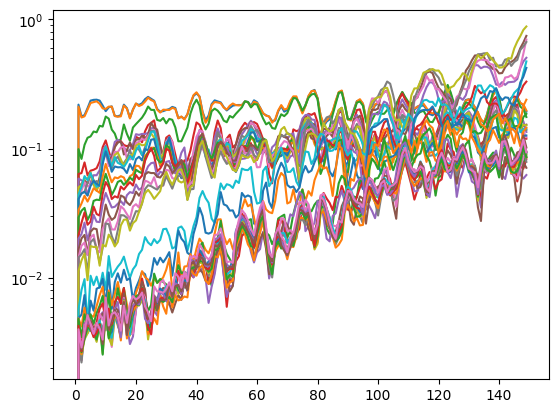

In [195]:
plt.semilogy(np.mean(dist,1).T)

In [108]:
xtest_real = xtest_real.reshape(37,4,96,10,150,46)

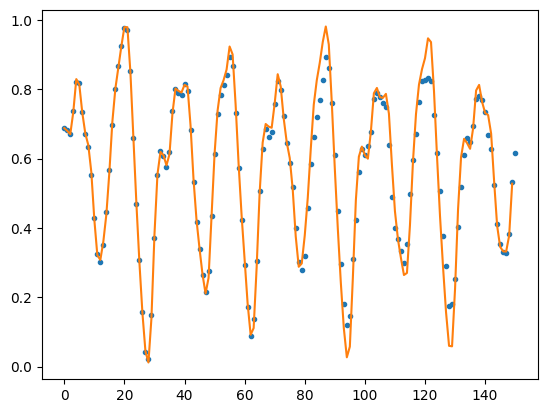

In [85]:
sk = np.load('../Input_MG.npy')
plt.plot(np.median(ytest[23,0],0)[1],'.')
plt.plot(sk[2150:2300])

In [237]:
result = qt.mesolve(qt.Qobj(H0.toarray(), dims=[[2]*2, [2]*2]) + qt.Qobj(H1.toarray(), dims=[[2]*2, [2]*2]), qt.Qobj(state0, dims = [[2]*2, [2]*2]), np.linspace(0, 10, 100), c_ops = [qt.Qobj(cop.toarray(), dims = [[2]*2, [2]*2]) for cop in cops], e_ops = [qt.tensor(qt.sigmax(), qt.identity(2)), qt.tensor(qt.sigmay(), qt.identity(2)), qt.tensor(qt.sigmaz(), qt.identity(2)), qt.tensor(qt.identity(2), qt.sigmax()), qt.tensor(qt.identity(2), qt.sigmay()), qt.tensor(qt.identity(2), qt.sigmaz())])

In [41]:
print(ridge)

RidgeCV(alphas=array([1.00000000e-09, 1.02804473e-09, 1.05687597e-09, 1.08651577e-09,
       1.11698682e-09, 1.14831241e-09, 1.18051653e-09, 1.21362380e-09,
       1.24765955e-09, 1.28264983e-09, 1.31862140e-09, 1.35560179e-09,
       1.39361927e-09, 1.43270295e-09, 1.47288272e-09, 1.51418933e-09,
       1.55665436e-09, 1.60031031e-09, 1.64519059e-09, 1.69132952e-09,
       1.73876240e-09, 1.78752553e-0...
       5.29326606e+02, 5.44171429e+02, 5.59432571e+02, 5.75121707e+02,
       5.91250841e+02, 6.07832313e+02, 6.24878807e+02, 6.42403366e+02,
       6.60419396e+02, 6.78940681e+02, 6.97981391e+02, 7.17556092e+02,
       7.37679760e+02, 7.58367791e+02, 7.79636013e+02, 8.01500696e+02,
       8.23978568e+02, 8.47086827e+02, 8.70843150e+02, 8.95265713e+02,
       9.20373200e+02, 9.46184819e+02, 9.72720319e+02, 1.00000000e+03]))


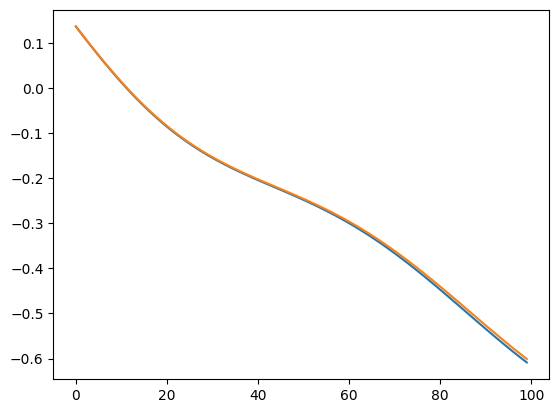

In [ ]:
plt.plot(result.expect[2], label = "X1")
plt.plot(misure[0:,2,0])

In [9]:
np.array([qs.local_operators(qs.sigmax(), Nq), qs.local_operators(qs.sigmay(), Nq), qs.local_operators(qs.sigmaz(), Nq)]).reshape(12, 16,16)

array([[[ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
        ...,
        [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j]],

       [[ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
        ...,
        [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j]],

       [[ 0.+0.j,  0.+0.j,  1.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
    

In [ ]:
state = qs.zero(dm = True, N = 4)
H0 = qs.sigmaz()
cops = []
state_t = qs.QRC.CD_evolution(np.random.random((100)), H1, H0, 0.1, 100, state)

AttributeError: module 'QuantumStuff' has no attribute 'local_operator'

In [ ]:
import warnings

import warnings

warnings.filterwarnings(
    action='ignore',
    category=RuntimeWarning,
    message=r'.*invalid value encountered in log2.*'
)

def von_neumann_entropy(state: np.ndarray):
    """
    Calculate the von Neumann entropy of a quantum state.
    The von Neumann entropy is defined as:
        S(ρ) = -Tr(ρ log2(ρ))

    where ρ is the density matrix of the quantum state.
    Args:
        state (np.ndarray): The quantum state, can be a density matrix or a pure state.
        ax (int): Axis along which to compute the entropy. Default is -1.
    Returns:
        np.ndarray: The von Neumann entropy of the state.
    """

    check = qs.is_state(state)
    if not check[1]:
        raise Exception("Input is not a valid quantum state")
    if check[0] != 3:
        state = qs.ket_to_dm(state)

    state = np.asarray(state, dtype = complex)

    eigs = np.linalg.eigvalsh(state)
    entropy = np.sum(-eigs * np.log2(eigs), axis = -1)
    if np.shape(entropy) == ():
        entropy = np.array([entropy])
    entropy[np.where(np.isnan(entropy))] = 0
    return entropy

state = qs.random_qubit(3, pure = False, dm = True) 
von_neumann_entropy(state)

array([2.37654684])

In [558]:
state = [qs.random_qubit(3, pure = True, dm = True) for i in range(10)]

np.any(np.isclose(np.linalg.eigvalsh(state), 1), axis = -1)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [228]:
H_test = np.sum([[J[i,j]*np.dot(z[i],z[j] )for i in range(3)] for j in range(3)], axis = (0,1))

In [229]:
np.allclose(H,H_test)

True

In [11]:
state = [qs.random_qubit(4, pure = True, dm = True) for i in range(10)]
qs.is_state(state)

(3, True)

In [5]:
qs.CD_evolution(np.random.random(10),qs.sigmax(), qs.sigmaz(), [qs.sigmay()], 0.1,  5, ρ = None, disable_progress_bar = False)

100%|██████████| 5/5 [00:00<00:00, 714.09it/s]


array([[[0.88563915-3.69494902e-26j, 0.01432705+1.46380481e-01j],
        [0.01432705-1.46380481e-01j, 0.11436085+3.73647723e-26j]],

       [[0.75999731-3.00523769e-26j, 0.04775592+2.40364020e-01j],
        [0.04775592-2.40364020e-01j, 0.24000269+3.38090441e-26j]],

       [[0.63323971-1.42454260e-19j, 0.08810637+2.90456364e-01j],
        [0.08810637-2.90456364e-01j, 0.36676029+1.46690436e-19j]],

       [[0.52064962-7.48714072e-19j, 0.12576854+2.93737455e-01j],
        [0.12576854-2.93737455e-01j, 0.47935038+7.60588079e-19j]],

       [[0.42013505-1.86174175e-18j, 0.15307276+2.53030154e-01j],
        [0.15307276-2.53030154e-01j, 0.57986495+1.94392272e-18j]]])

In [79]:
state = qs.random_qubit(4, pure = True, dm = True)
meas = measure([state]*10, [qs.sigmax()]*3)
measure2 = qs.measure(state, [np.kron(qs.sigmaz(), qs.sigmaz())]*5)
meas.shape

(10, 3, 4)

In [11]:
a = np.random.random((2,4,4))
b = np.random.random((3,4,4))
(a[:, np.newaxis]@b[np.newaxis,:]).shape

(2, 3, 4, 4)

In [3]:
from tqdm import tqdm
N = 5
Js = 1
J = qso.random_coupling(Js, N)
X = qs.local_operators(qs.sigmax(), N)
Z = qs.local_operators(qs.sigmaz(), N)
h = 0.1
H0 = np.sum(qso.interaction(X, J) + h*Z ,0)
H1 = h*np.sum(X,0)
stato = qs.random_qubit(N, pure = True, dm = True)
ρ = stato
σm = qs.local_operators(qs.sigmam(), N)

states = []
dt = 10/370
ρt = np.zeros((370,2**N,2**N), dtype = complex)
    
sh = sp.csc_matrix(qso.Super_H(H0), dtype = complex)
sd = sp.csc_matrix(qso.Super_D(σm), dtype = complex)

def Lindblad_Propagator(SH: np.ndarray | sp.csc_matrix, SD: np.ndarray | sp.csc_matrix, dt: float, ρ: np.ndarray):
    """
    Lindblad propagator for Lindblad equation
    :L: super operator
    :dt: time step
    :ρ: density matrix
    :return: propagated density matrix
    """
    L = SH + SD
    is_sparse = type(L) == sp.csc_matrix or sp.csc_array
    if ρ.ndim != 1:
        ρ = ρ.flatten()
    if is_sparse:
        return expm_multiply(L, ρ, start = 0 , stop = dt, num = 2)[-1]
    else:
        return expm(L * dt) @ ρ
    
def CD_evolution(sk: np.ndarray, H1: np.ndarray | sp.csc_matrix | sp.csc_array, H0: np.ndarray | sp.csc_matrix | sp.csc_array, c_ops: list, δt: float,  steps: int, ρ = None):
    #Evolution
    Nq = int(np.log2(H0.shape[0]))
    superd = sp.csc_matrix(qso.Super_D(c_ops), dtype = complex)
    if ρ is None:
        ρ = qso.zero(dm = True, N = Nq)
    ρt = np.zeros((steps, 2**Nq, 2**Nq), dtype = complex)
    for i in tqdm(range(steps)):
        superh = sp.csc_matrix(qso.Super_H(H0 + (sk[i] + 1)*H1), dtype = complex)
        ρt[i] = Lindblad_Propagator(superh, superd, δt, ρ).reshape(2**Nq, 2**Nq)
        ρ = ρt[i]

    return ρt
sk = np.random.random(30)
ρt = CD_evolution(sk, H1, H0, σm, dt, 30, stato)
states = (qs.measure(ρt, qs.sigmaz()))

100%|██████████| 30/30 [00:01<00:00, 22.93it/s]


In [37]:
for i in tqdm(range(10),disable=False):
    print(i)


100%|██████████| 10/10 [00:00<00:00, 1575.21it/s]

0
1
2
3
4
5
6
7
8
9


In [35]:
state = qs.random_qubit(4, pure = True, dm = False)
qs.is_state(evolve_unitary(U, state))

(3, True)

In [13]:
U = qs.haar_random_unitary(4)
state = np.array([qs.random_qubit(4, pure = True, dm = True) for i in range(5)])
qs.is_state(U@state@qs.dag(U))

(3, True)

In [ ]:
state = np.array([qs.random_qubit(4, pure = True, dm = False) for i in range(5)])
np.outer(state, qs.dag(state))

(80, 80)

In [22]:
rho = np.array(qs.random_qubit(4, pure = True, dm = False) )
if rho.ndim == 1 or (rho.shape[0] != rho.shape[1] and rho.ndim == 2):
    print('porcodio')
    rho = qs.ket_to_dm(rho)


porcodio


In [3]:
state_ivp = qs.evolve_lindblad(stato, H, np.arange(0, 10, 10/370), c_ops = σm)

In [ ]:
[0,dt]

array([0.])

In [61]:
c_ops = [qt.Qobj(c, dims = [[2 for i in range(N)] for j in range(2)]) for c in σm]
eops = [qt.Qobj(e, dims = [[2 for i in range(N)] for j in range(2)]) for e in (Z)]
H0 = qt.Qobj(H0, dims = [[2 for i in range(N)] for j in range(2)])
H1 = qt.Qobj(H1, dims = [[2 for i in range(N)] for j in range(2)])

stato = qt.Qobj(stato, dims = [[2 for i in range(N)] for j in range(2)])
state_qutip = np.zeros((30,5), dtype = complex)
for k in tqdm(range(30)):
    state_update = qt.mesolve(H0 + (1+sk[k])*H1, stato, [0,dt], c_ops = c_ops, e_ops = eops, options = {'store_final_state': True})
    stato = state_update.final_state
    state_qutip[k] = np.array(state_update.expect)[:,-1]

100%|██████████| 30/30 [01:00<00:00,  2.01s/it]


In [57]:
np.array(state_update.expect)[:,-1]

array([-0.19260371, -0.20577622,  0.10719096,  0.01785502, -0.05879561])

In [14]:
m_qtp = state_qutip.expect

In [6]:
state_ivp = state_ivp.T.reshape(370, 2**5, 2**5)


In [35]:
state_qutip.shape

(370, 32, 32)

In [62]:
# m_ivp = qs.measure(state_ivp, qs.sigmax())
m_qso = qs.measure(ρt, qs.sigmaz())
# m_qutip = qs.measure(state_qutip, qs.sigmaz())


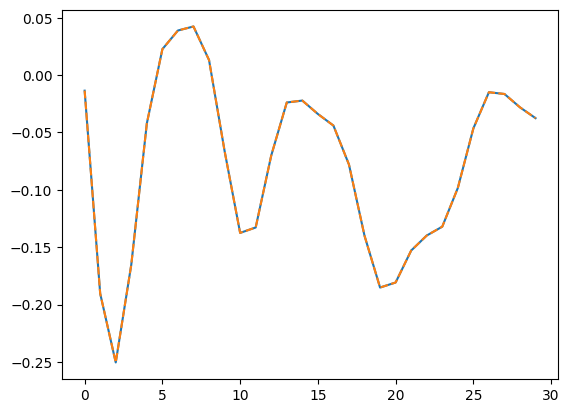

In [64]:
import matplotlib.pyplot as plt

# plt.plot(m_ivp[:,0,0],'.')
plt.plot(states[:,0,1])
# plt.plot(m_qutip[0,0,:,0],'.')
plt.plot(np.array(state_qutip)[:,1],'--')

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from collections import deque

# Parameters for the Mackey-Glass system
tau = 17.0
beta = 0.2
gamma = 0.1
n = 10

# Define the delayed Mackey-Glass master system
def mackey_glass(t, x_t, x_tau):
    return beta * x_tau / (1 + x_tau**n) - gamma * x_t

# Slave system depends explicitly on time and master state x(t)
def g(t, x, y):
    return np.array([y[1], -y[0] + (1 - y[0]**2) * y[1] + 0.1 * np.sin(t) * (x - y[0])])

# Full system with delay embedded
class MackeyGlassMasterSlave:
    def __init__(self, tau, history_len=1000):
        self.tau = tau
        self.history_len = history_len
        self.history = deque(maxlen=history_len)

    def __call__(self, t, z):
        x, y = z[0], z[1:]
        self.history.append((t, x))

        # Interpolate x(t - tau)
        if len(self.history) < 2:
            x_tau = x  # Initial estimate
        else:
            t_vals, x_vals = zip(*self.history)
            if t - self.tau < t_vals[0]:
                x_tau = x_vals[0]
            else:
                f_interp = interp1d(t_vals, x_vals, bounds_error=False, fill_value=(x_vals[0], x_vals[-1]))
                x_tau = f_interp(t - self.tau)

        dx = mackey_glass(t, x, x_tau)
        dy = g(t, x, y)
        return np.concatenate([[dx], dy])

# Initial condition for the system
Z0 = np.array([1.2, 1.0, 0.0])  # [x, y1, y2]

# Instantiate the system
system = MackeyGlassMasterSlave(tau)

# Jacobian approximation using finite differences
def finite_diff_jacobian(f, z, t, eps=1e-6):
    n = len(z)
    J = np.zeros((n, n))
    for i in range(n):
        dz = np.zeros(n)
        dz[i] = eps
        J[:, i] = (f(t, z + dz) - f(t, z - dz)) / (2 * eps)
    return J

# Variational equations
Z0_var = Z0
perturbations = np.eye(len(Z0))
Zvar0 = np.concatenate([Z0_var, perturbations.flatten()])


def variational_equations(t, Z):
    n = len(Z0)
    z = Z[:n]
    X = Z[n:].reshape((n, n))
    dz = system(t, z)
    Jz = finite_diff_jacobian(system, z, t)
    dX = Jz @ X
    return np.concatenate([dz, dX.flatten()])

# Time span
Tmax = 200

# Solve the variational equations
sol = solve_ivp(variational_equations, [0, Tmax], Zvar0, t_eval=np.linspace(0, Tmax, 20000))

# QR-based computation of Lyapunov exponents
def compute_lyapunov(sol):
    n = len(Z0)
    m = len(sol.t)
    Q = np.eye(n)
    lyap = np.zeros(n)
    for i in range(1, m):
        X = sol.y[n:, i].reshape((n, n))
        Q, R = np.linalg.qr(X @ Q)
        lyap += np.log(np.abs(np.diag(R)))
    return lyap / (sol.t[-1] - sol.t[0])

lyapunov_exponents = compute_lyapunov(sol)
print("Lyapunov exponents:", lyapunov_exponents)


Lyapunov exponents: [ 5.27553880e-01 -9.99809348e+02 -3.30518583e+03]
